In [18]:
import torchvision.transforms as transforms
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import os 
from PIL import Image

In [19]:
df = pd.read_csv("annotation_frame.csv")
df.head()

,filename,max_x,max_y,min_x,min_y,label
0,AgNOR_0495.tiff,26,41,4,15,1
1,AgNOR_0495.tiff,71,23,42,0,2
2,AgNOR_0495.tiff,133,61,104,37,1
3,AgNOR_0495.tiff,143,117,121,88,2
4,AgNOR_0495.tiff,224,37,199,12,1


In [20]:
# define the custom augementations 

class CustomAugmentation:
    def guassian_blur(self,img):
        kernel_size = np.random.choice([3, 5, 7])  # Randomly choose kernel size

        # Convert PIL Image to NumPy array
        img_np = np.array(img)

        # Apply blur to each channel separately
        blurred_img = np.zeros_like(img_np)
        for i in range(img_np.shape[2]):
            blurred_img[:, :, i] = self.convolution(img_np[:, :, i], self.gaussian_kernel(kernel_size))
        
        # Convert NumPy array back to PIL Image
        blurred_img_pil = Image.fromarray(blurred_img)

        return blurred_img_pil
    
  
    def color_jitter(self,image, brightness=1, contrast=2.5, saturation=1.5, hue=0.5):
        # Apply color jitter to the image
        image = transforms.functional.adjust_brightness(image, brightness)
        image = transforms.functional.adjust_contrast(image, contrast)
        image = transforms.functional.adjust_saturation(image, saturation)
        image = transforms.functional.adjust_hue(image, hue)
        
        return image
        

    def gaussian_kernel(self, size, sigma=1):
        """
        Generate a 2D Gaussian kernel.
        Args:
            size (int): Size of the kernel (should be odd).
            sigma (float): Standard deviation of the Gaussian distribution.
        Returns:
            numpy.ndarray: 2D Gaussian kernel.
        """
        kernel = np.fromfunction(lambda x, y: (1 / (2 * np.pi * sigma ** 2)) * np.exp(
            -(x - size // 2) ** 2 / (2 * sigma ** 2) - (y - size // 2) ** 2 / (2 * sigma ** 2)),
                                  (size, size))
        return kernel / np.sum(kernel)
    
    def convolution(self, img, kernel):
        """
        Perform 2D convolution between image and kernel.
        Args:
            img (numpy.ndarray): Input image.
            kernel (numpy.ndarray): Convolution kernel.
        Returns:
            numpy.ndarray: Convolved image.
        """
        padding = kernel.shape[0] // 2
        img_padded = np.pad(img, padding, mode='constant')
        convolved_img = np.zeros_like(img)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                convolved_img[i, j] = np.sum(img_padded[i:i + kernel.shape[0], j:j + kernel.shape[1]] * kernel)
        return convolved_img
    


In [21]:
class AGNORsDataset(Dataset):
    def __init__(self, df, num_samples=1000 , img_dir='AgNORs/'):
        self.df = df
        self.num_samples = num_samples
        self.init_samples() 
        self.img_path = img_dir
        self.transform = self.transforms() 

    
    def transforms(self):
        custom_augmentations = CustomAugmentation()
        transform = transforms.Compose([
            transforms.Resize((50,50)),
            transforms.Lambda(custom_augmentations.color_jitter),
            transforms.Lambda(custom_augmentations.guassian_blur),
            transforms.ToTensor(),
    
        ])
        return transform


    def init_samples(self):
        num_samples_per_class = self.num_samples // len(self.df['label'].unique())
        
        minority_samples = []
        for label in self.df['label'].unique():
            minority_samples.append(self.df[self.df['label'] == label].sample(num_samples_per_class, replace=True))
        minority_df = pd.concat(minority_samples)

        majority_samples = self.df[~self.df.index.isin(minority_df.index)].sample(self.num_samples - len(minority_df), replace=True)

        self.samples = pd.concat([minority_df, majority_samples])

        return self.samples 

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_path, self.df.iloc[idx, 0])
        label = self.samples.iloc[idx]['label']
        img = Image.open(img_path).convert('RGB')
        crop_image = img.crop((self.df.iloc[idx, 3], self.df.iloc[idx, 4], self.df.iloc[idx, 1], self.df.iloc[idx, 2])) 
        img = self.transform(crop_image)
        
        return img, label

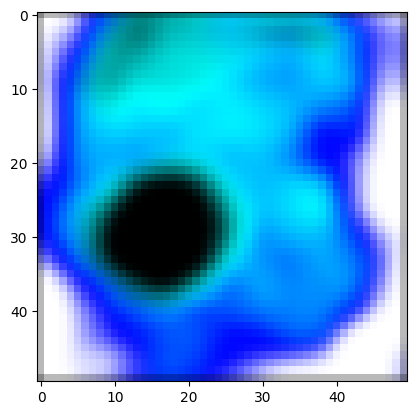

In [22]:
data = AGNORsDataset(df)

img = data.__getitem__(99)[0]

img_np = img.permute(1, 2, 0).numpy()

# img_np = transforms.ToPILImage()(img)
plt.imshow(img_np)

# img_np.show()


In [23]:
samples = data.init_samples()

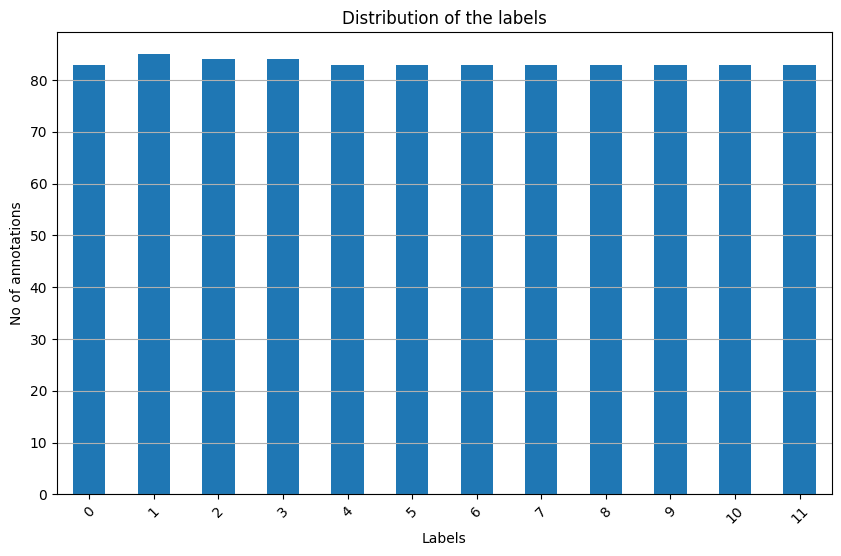

In [24]:
plt.figure(figsize=(10,6))
samples['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of the labels')
plt.xlabel('Labels')
plt.ylabel('No of annotations')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()